At first we import all the needed libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

After that we import the data and define the the features X and the target value y. 
We need to create a new column "Quality" for the classification. If the Ra value is in the borders the surface is good and if not the surface is bad.
We also split the data in test and train-data for the . After that we split the train data into the final train-data and the validation part.

In [2]:
# Importing the data
dataset = pd.read_excel('/Users/mustafa/Documents/GitHub/ML_knife_QA/data/chiefs_knife_dataset.xlsx')
index_Ra = dataset.columns.get_loc('Ra')  # Index der Spalte für Rauheit

# Specification limits
LOWER_SPECIFICATION_LIMIT = 0.125
UPPER_SPECIFICATION_LIMIT = 0.215

# Classification into "good" and "bad"
is_between_specification_bounds = (dataset['Ra'] >= LOWER_SPECIFICATION_LIMIT) & (dataset['Ra'] < UPPER_SPECIFICATION_LIMIT)
good_product_range = np.where(is_between_specification_bounds, "good", "bad")
dataset.insert(index_Ra + 1, 'Quality', good_product_range)

# Features and target value
X = dataset.loc[:, 'Original_Linienanzahl':'DFT_Median_sobel_Bereich'].values
y = dataset['Quality'].values
y = np.where(y == 'good', 0, 1)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Now data augmentation is used to get more values out of the given data. 

In [3]:
# Data augmentation through the addition of noise
noise = np.random.normal(0, 0.01, X_train.shape)  # Noise with mean value 0 and standard deviation 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels stay the same

# Combining original and augmented features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

Now the features get scaled because there are some features with very low values and some with very high values. After the scaling the features are in the same range.

In [4]:
# Feature-Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Now the raw model is trained with the RandomForestClassifier and the validation and test part are predicted. To analyze the model the accuracy and a report with precision, recall, f1-score and support is printed. 
Additionally the confusion matrix is calculated and plotted for the raw model.

Accuracy (Original Model - Validation): 0.7290748898678414
Classification Report (Original Model - Validation):
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       737
           1       0.73      0.65      0.69       625

    accuracy                           0.73      1362
   macro avg       0.73      0.72      0.72      1362
weighted avg       0.73      0.73      0.73      1362


Accuracy (Original Model): 0.7526439482961222
Classification Report (Original Model):
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       904
           1       0.77      0.68      0.72       798

    accuracy                           0.75      1702
   macro avg       0.75      0.75      0.75      1702
weighted avg       0.75      0.75      0.75      1702




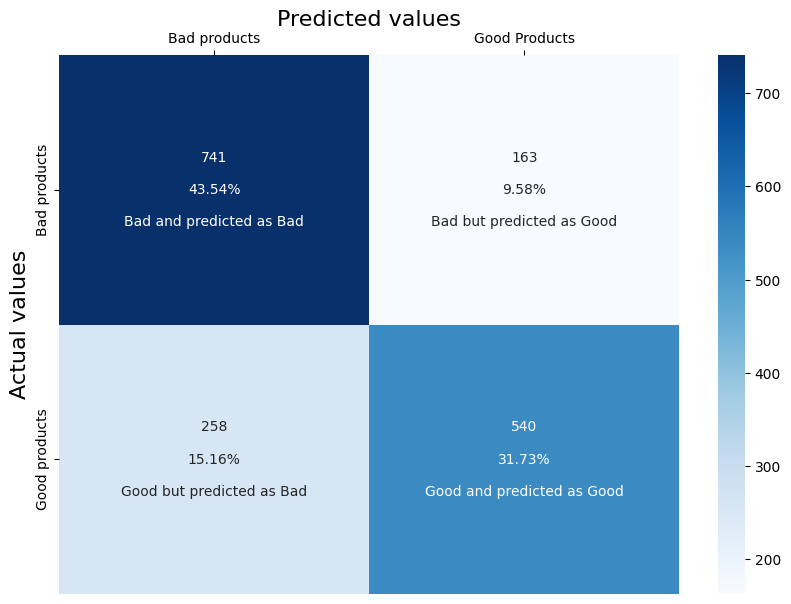

In [5]:
# Modeltraining with RandomForestClassifier (before optimizing with Randomized Search)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_scaled, y_train)
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}

# Prediction
y_pred = classifier.predict(X_test_scaled)
y_val_pred = classifier.predict(X_val_scaled)

# Validation - Evaluation
accuracy_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)
print(f'Accuracy (Original Model - Validation): {accuracy_val}')
print(f'Classification Report (Original Model - Validation):\n{report_val}\n')

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy (Original Model): {accuracy}')
print(f'Classification Report (Original Model):\n{report}\n')

# Confusion Matrix for the originalmodel
cm_original = confusion_matrix(y_test, y_pred)

# Plot of the confusion matrix
plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_original.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_original.flatten()/np.sum(cm_original)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_original, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_original.png', dpi=300)

To optimize the model a hyperparameter tuning is used. The method is the randomized search.
After the best model is found the tuned hyperparameters are printed and the new model is fitted with the train data.

In [6]:
# Hyperparameter grid for randomized search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Randomized Search for Random Forest Classifier
random_search_classifier = RandomizedSearchCV(estimator=classifier,
                                              param_distributions=param_grid, 
                                              n_iter=100,  # Number of random combinations
                                              cv=5,        # Cross-Validation folds
                                              scoring='accuracy',  # Search for the HP combination with the best accuracy
                                              n_jobs=-1,   # Use all available cores
                                              verbose=0,   # Verbosity level
                                              random_state=42)  # For reproducibility

# Fitting the model with the optimized hyperparamaters
random_search_classifier.fit(X_train_scaled, y_train)

# Best model based on the search
best_model = random_search_classifier.best_estimator_

# Output of the best hyperparameters
print(f'Best hyperparameters for classifier:\n{random_search_classifier.best_params_}\n')

Best hyperparameters for classifier:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}



Now the values get predicted with the best model and is also evaluated with the accuracy and a report with precision, recall, f1-score and support. 
The confusion matrix is also calculated and printed for the good model.

Accuracy (Best Model - Validation): 0.7276064610866373
Classification Report (Best Model - Validation):
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       737
           1       0.73      0.64      0.68       625

    accuracy                           0.73      1362
   macro avg       0.73      0.72      0.72      1362
weighted avg       0.73      0.73      0.73      1362


Best Model Accuracy: 0.7520564042303173
Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       904
           1       0.76      0.68      0.72       798

    accuracy                           0.75      1702
   macro avg       0.75      0.75      0.75      1702
weighted avg       0.75      0.75      0.75      1702




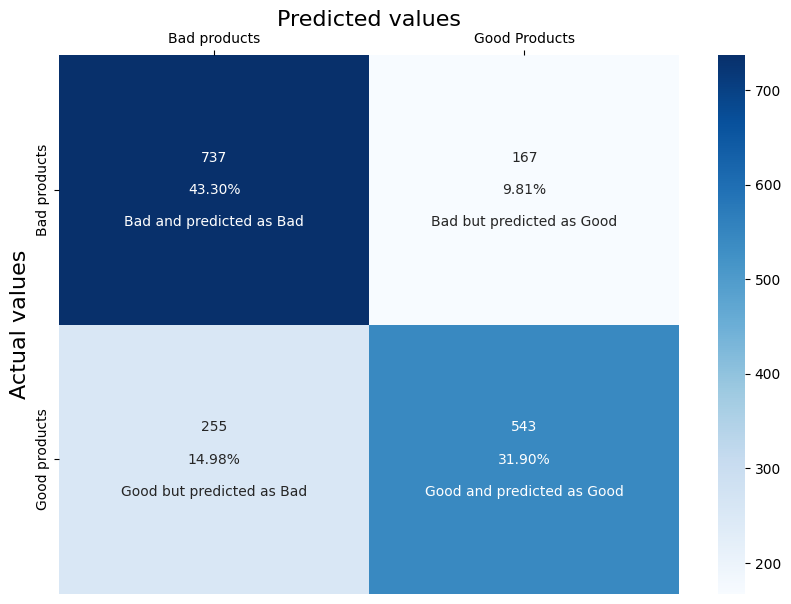

In [7]:
# Vorhersagen mit dem besten Modell
y_pred_best = best_model.predict(X_test_scaled)
y_val_pred_best = best_model.predict(X_val_scaled)

# Validation - Evaluierung
accuracy_val_best = accuracy_score(y_val, y_val_pred_best)
report_val_best = classification_report(y_val, y_val_pred_best)
print(f'Accuracy (Best Model - Validation): {accuracy_val_best}')
print(f'Classification Report (Best Model - Validation):\n{report_val_best}\n')

# Evaluierung des besten Modells
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')
print(f'Best Model Classification Report:\n{report_best}\n')

# Confusion Matrix für das optimierte Modell mit y_test
cm_best = confusion_matrix(y_test, y_pred_best)

# Plot of the confusion matrix
plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_best.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_best.flatten()/np.sum(cm_best)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_best, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_best.png', dpi=300)

Another method for possible optimization are the feature importances. They are calculated and are printed in a graph and a list.

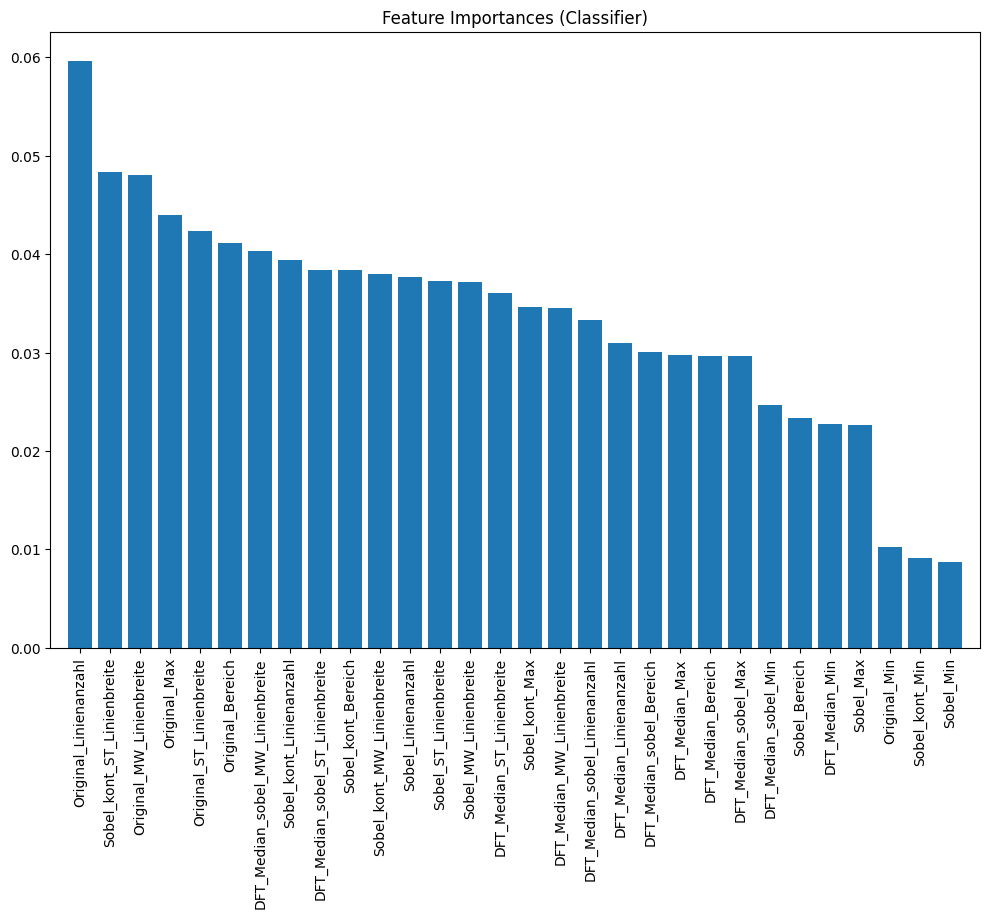

                             Feature  Importance
0              Original_Linienanzahl    0.059611
1         Sobel_kont_ST_Linienbreite    0.048347
2           Original_MW_Linienbreite    0.048030
3                       Original_Max    0.043937
4           Original_ST_Linienbreite    0.042347
5                   Original_Bereich    0.041170
6   DFT_Median_sobel_MW_Linienbreite    0.040333
7            Sobel_kont_Linienanzahl    0.039364
8   DFT_Median_sobel_ST_Linienbreite    0.038378
9                 Sobel_kont_Bereich    0.038348
10        Sobel_kont_MW_Linienbreite    0.038016
11                Sobel_Linienanzahl    0.037715
12             Sobel_ST_Linienbreite    0.037294
13             Sobel_MW_Linienbreite    0.037156
14        DFT_Median_ST_Linienbreite    0.036081
15                    Sobel_kont_Max    0.034677
16        DFT_Median_MW_Linienbreite    0.034563
17     DFT_Median_sobel_Linienanzahl    0.033263
18           DFT_Median_Linienanzahl    0.031010
19          DFT_Medi

<Figure size 640x480 with 0 Axes>

In [8]:
# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Names of the features
feature1 = dataset.columns.get_loc('Original_Linienanzahl')
feature2 = dataset.columns.get_loc('DFT_Median_sobel_Bereich')
feature_names = dataset.columns[feature1:feature2+1]

# Visualization of the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Classifier)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
plt.savefig('feature_importances_classifier.png', dpi=300)

# Output of the feature importances
feature_importances = pd.DataFrame({'Feature': feature_names[indices], 'Importance': importances[indices]})
print(feature_importances)



In this function a treshold can be chosen and all the features with lower importances are dropped automatically.

In [14]:

def select_relevant_features(threshold):
    # Filter the features with importance < treshold
    important_features = feature_importances[feature_importances['Importance'] >= threshold]

    # List of features to keep
    features_to_keep = important_features['Feature'].values

    # Selection of the corresponding columns from the original DataFrame
    X_important = dataset[features_to_keep]
    return X_important

threshold = 0.03
X_important = select_relevant_features(threshold)

Completely new train-test split, data augmentation, model training and prediction.


Accuracy (Original Model - Validation): 0.7408223201174743
Classification Report (Original Model - Validation):
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       737
           1       0.74      0.66      0.70       625

    accuracy                           0.74      1362
   macro avg       0.74      0.73      0.74      1362
weighted avg       0.74      0.74      0.74      1362


Accuracy (Original Model): 0.7596944770857814
Classification Report (Original Model):
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       904
           1       0.77      0.69      0.73       798

    accuracy                           0.76      1702
   macro avg       0.76      0.76      0.76      1702
weighted avg       0.76      0.76      0.76      1702




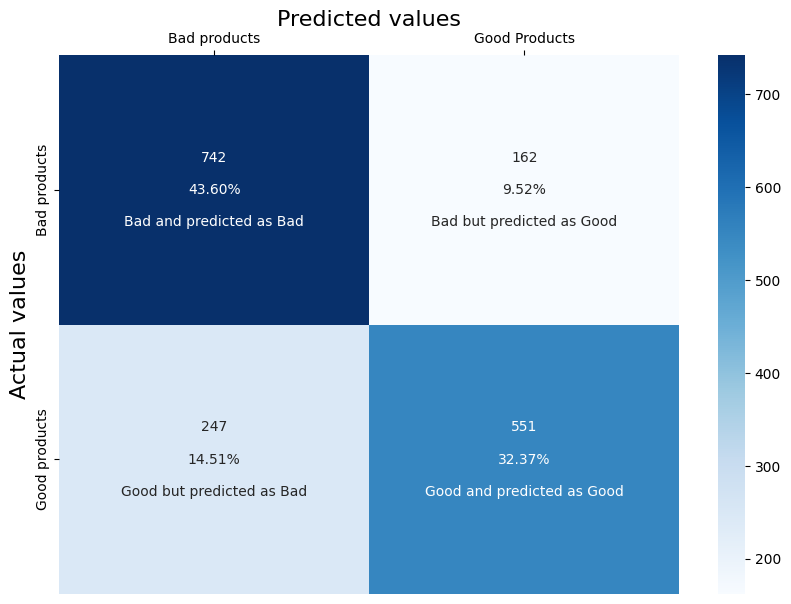

In [15]:
# Convert DataFrame to NumPy array before the train-test split
X_important = X_important.values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data augmentation through the addition of noise
noise = np.random.normal(0, 0.01, X_train.shape)  # Noise with mean value 0 and standard deviation 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels stay the same

# Combining original and augmented features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

# Feature-Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


# Modeltraining with RandomForestClassifier (after dropping features with low importance)
classifier_dropped = RandomForestClassifier(random_state=42)
classifier_dropped.fit(X_train_scaled, y_train)

# Prediction
y_pred_dropped = classifier_dropped.predict(X_test_scaled)
y_val_pred_dropped = classifier_dropped.predict(X_val_scaled)

# Validation - Evaluation
accuracy_val_dropped = accuracy_score(y_val, y_val_pred_dropped)
report_val_dropped = classification_report(y_val, y_val_pred_dropped)
print(f'\nAccuracy (Original Model - Validation): {accuracy_val_dropped}')
print(f'Classification Report (Original Model - Validation):\n{report_val_dropped}\n')

# Evaluation
accuracy_dropped = accuracy_score(y_test, y_pred_dropped)
report_dropped = classification_report(y_test, y_pred_dropped)
print(f'Accuracy (Original Model): {accuracy_dropped}')
print(f'Classification Report (Original Model):\n{report_dropped}\n')

# Confusion Matrix for the model with dropped features
cm_dropped = confusion_matrix(y_test, y_pred_dropped)

# Plot of the confusion matrix
plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_dropped.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_dropped.flatten()/np.sum(cm_dropped)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_dropped, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_dropped.png', dpi=300)